<a href="https://colab.research.google.com/github/seohwan2/vaiv_project/blob/main/VGG16CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import os
import torchvision.models as models
import torch.nn.functional as F
import math
import time

device = 'cuda'

# Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch >= 30:
        lr /= 2
    if epoch >= 60:
        lr /= 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Xavier         
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform(m.weight)

In [20]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
class VGG(nn.Module):
    def __init__(self, config, num_classes=1000, cifar=False):
        super(VGG, self).__init__()
        self.features = make_layer(config)
        
        # ImageNet
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  
        )
        if cifar:
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, 512),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(512, 512),
                nn.ReLU(True),
                nn.Linear(512, 10)  
            ) 
        
    def forward(self, x):
        out = self.features(x)
        out = torch.flatten(out,1)
        out = self.classifier(out)
        return out
    

    
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layer(config):
    layers = []
    in_planes = 3
    for value in config:
        if value == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_planes = value
    return nn.Sequential(*layers)

def VGG11(cifar=False):
    return VGG(config = cfg['A'], cifar = cifar)

def VGG13(cifar=False):
    return VGG(config = cfg['B'], cifar = cifar)

def VGG16(cifar=False):
    return VGG(config = cfg['D'], cifar = cifar)

def VGG19(cifar=False):
    return VGG(config = cfg['E'], cifar = cifar)

model = VGG16(cifar=True)
# VGG11, VGG13, VGG16, VGG19 중에 택일하여 사용
model.apply(init_weights)
model = model.to(device)

learning_rate = 0.05
num_epoch = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [27]:
x = []
y = []
for epoch in range(num_epoch):
    start = time.time()
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    #avg_cost = 0
    for step, batch in enumerate(train_loader):
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        #avg_cost += loss / total_cnt
    x.append(epoch+1)
    y.append(loss.item())
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    print(f"Train Acc : { correct*100 / total_cnt }")
    print(f"Train Loss : {loss.item()}")
    print(f"Train Time : {time.time()-start}")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


====== 1 epoch of 10 ======
Train Acc : 13.378
Train Loss : 0.11759732663631439
Train Time : 21.13067364692688
====== 2 epoch of 10 ======
Train Acc : 17.048
Train Loss : 0.11410100013017654
Train Time : 21.466675996780396
====== 3 epoch of 10 ======
Train Acc : 26.554
Train Loss : 0.09636687487363815
Train Time : 21.34937286376953
====== 4 epoch of 10 ======
Train Acc : 34.53
Train Loss : 0.08975902199745178
Train Time : 21.170762062072754
====== 5 epoch of 10 ======
Train Acc : 42.17
Train Loss : 0.08370480686426163
Train Time : 21.268723487854004
====== 6 epoch of 10 ======
Train Acc : 52.206
Train Loss : 0.07419523596763611
Train Time : 21.38467001914978
====== 7 epoch of 10 ======
Train Acc : 59.082
Train Loss : 0.06347602605819702
Train Time : 21.3184597492218
====== 8 epoch of 10 ======
Train Acc : 63.782
Train Loss : 0.05580247938632965
Train Time : 21.381881952285767
====== 9 epoch of 10 ======
Train Acc : 67.104
Train Loss : 0.049730829894542694
Train Time : 21.22605562210083

In [33]:
# Test Phase
with torch.no_grad():
        times = []
        pred = []
        model.eval()
        for step, batch in enumerate(test_loader):
            start = time.time()
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            pred.append(predict)
            times.append(time.time()-start)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nAccuarcy : { valid_acc *100 }")  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Accuarcy : 70.25375


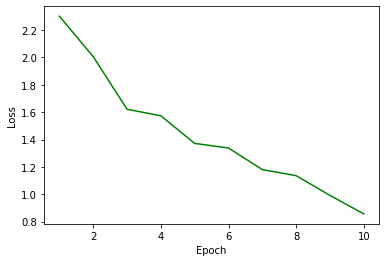

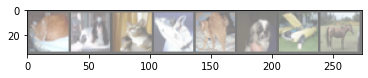

In [34]:
import matplotlib.pyplot as plt
import numpy as np
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

plt.plot(x, y, 'g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
testloader1 = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
for data in testloader1:
    img, label = data 
    img1 = torchvision.utils.make_grid(img)
    img1 = img1 / 2 + 0.5
    npimg = img1.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [1]:
print('Accuracy : {0}%' .format(valid_acc*100))
num = 1 
for i in range(8):
    if(label[i] == pred[i]):
        str = '{2}번째 예측 결과값은 : Label {0}, Predict {1} => Correct! / {2}번째 이미지 분류하는데 걸린 시간 : {3}'.format(NAMES[label[i]], NAMES[int(pred[i].item())],num,times[i])
    else:
        str = '{2}번째 예측 결과값은 : Label {0}, Predict {1} => Not correct! / {2}번째 이미지 분류하는데 걸린 시간 : {3}'.format(NAMES[label[i]], NAMES[int(pred[i].item())],num,times[i])
    print(str)
    num+=1

NameError: ignored